In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.logging.set_verbosity(tf.logging.ERROR)

#### Load Data
We're using a filtered version of Cat & Dog data on Kaggle provided by Microsoft research

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 0s 0us/step


The dataset we have downloaded has the following directory structure. 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [4]:
#on Linux
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print 

/tmp/.keras/datasets
/tmp/.keras/datasets/cats_and_dogs_filtered
/tmp/.keras/datasets/cats_and_dogs_filtered/train
/tmp/.keras/datasets/cats_and_dogs_filtered/train/cats
/tmp/.keras/datasets/cats_and_dogs_filtered/train/dogs
/tmp/.keras/datasets/cats_and_dogs_filtered/validation
/tmp/.keras/datasets/cats_and_dogs_filtered/validation/cats
/tmp/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [5]:
# on Windows
#!tree $zip_dir_base

In [6]:
#Assign variables to the paths accordingly
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


#### SETTING MODEL PARAMETERS

In [9]:
BATCH_SIZE = 100
IMG_SHAPE = 150

#### DATA AUGMENTATION

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass  different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#### Flipping the image horizontally

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This ia achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [11]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


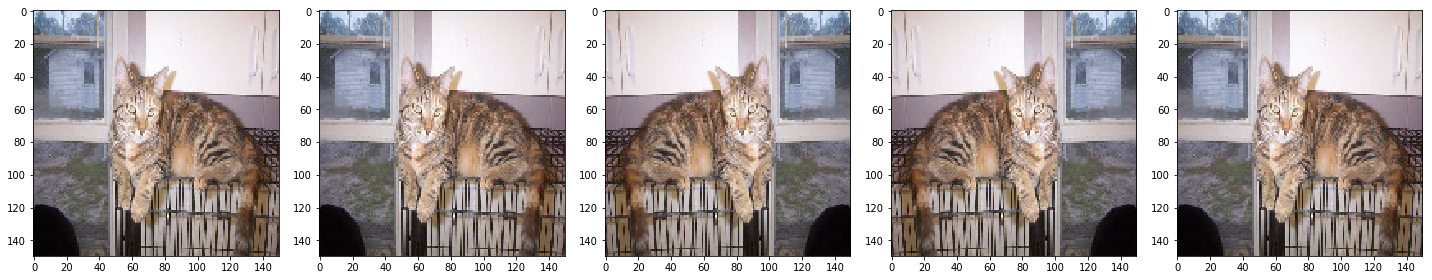

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Rotating the image

The rotation augmentation will randomly rotate the image up to a specfied number of degrees. Here, we'll set it to 45.

In [13]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=train_dir,
                                          shuffle=True,
                                          target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

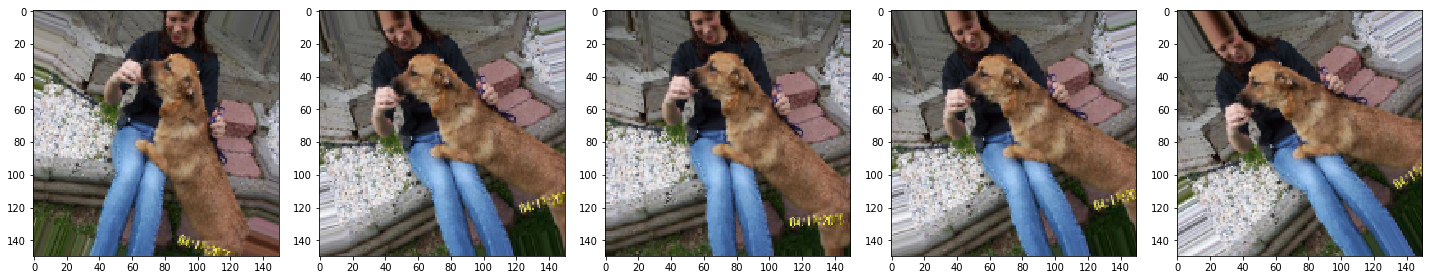

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Applying Zoom

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

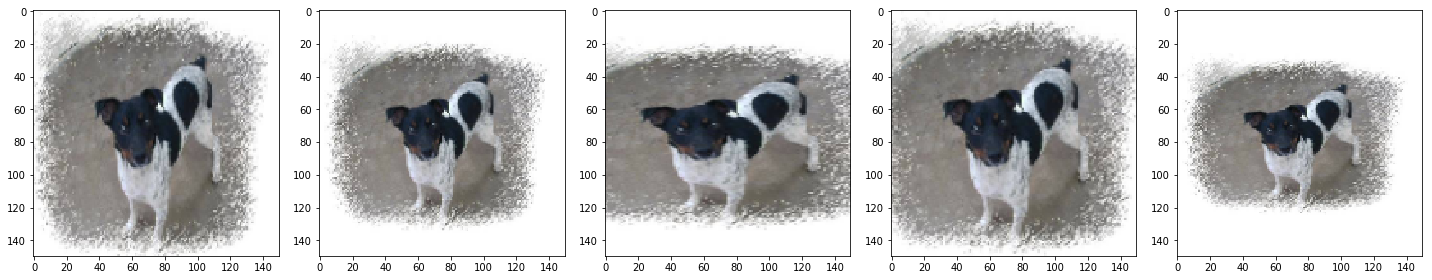

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Putting it all together

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.


In [17]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


Once again, let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

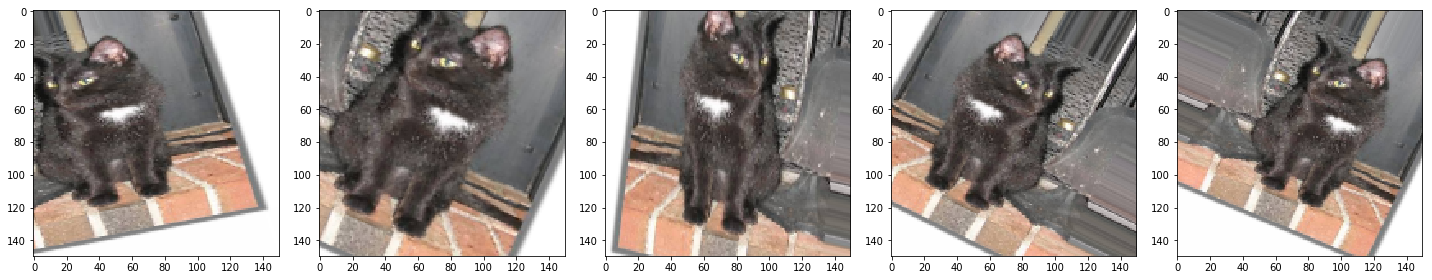

In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.


In [19]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=validation_dir,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


### Creating the model

Unlike our last model, before the final Dense layers, we're applying a Dropout probability of 0.5. This mean that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5), # Dropout Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [21]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [22]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

##### Train the model:
Since the batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`

In [23]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 16s 808ms/step - loss: 0.7181 - acc: 0.4970 - val_loss: 0.6920 - val_acc: 0.5000
Epoch 2/100
20/20 [==============================] - 14s 722ms/step - loss: 0.6920 - acc: 0.5140 - val_loss: 0.6869 - val_acc: 0.6530
Epoch 3/100
20/20 [==============================] - 14s 707ms/step - loss: 0.6777 - acc: 0.5660 - val_loss: 0.7367 - val_acc: 0.5080
Epoch 4/100
20/20 [==============================] - 14s 712ms/step - loss: 0.6689 - acc: 0.5775 - val_loss: 0.6364 - val_acc: 0.6220
Epoch 5/100
20/20 [==============================] - 14s 711ms/step - loss: 0.6516 - acc: 0.6180 - val_loss: 0.6546 - val_acc: 0.6010
Epoch 6/100
20/20 [==============================] - 14s 712ms/step - loss: 0.6444 - acc: 0.6165 - val_loss: 0.6252 - val_acc: 0.6430
Epoch 7/100
20/20 [==============================] - 14s 705ms/step - loss: 0.6259 - acc: 0.6525 - val_loss: 0.6002 - val_acc: 0.6530
Epoch 8/100
20/20 [==============================] - 14s 716ms

Epoch 62/100
20/20 [==============================] - 14s 701ms/step - loss: 0.3330 - acc: 0.8550 - val_loss: 0.3873 - val_acc: 0.8340
Epoch 63/100
20/20 [==============================] - 14s 702ms/step - loss: 0.2903 - acc: 0.8720 - val_loss: 0.4594 - val_acc: 0.8150
Epoch 64/100
20/20 [==============================] - 14s 700ms/step - loss: 0.2988 - acc: 0.8675 - val_loss: 0.4933 - val_acc: 0.7990
Epoch 65/100
20/20 [==============================] - 14s 724ms/step - loss: 0.3031 - acc: 0.8745 - val_loss: 0.4105 - val_acc: 0.8290
Epoch 66/100
20/20 [==============================] - 14s 710ms/step - loss: 0.3060 - acc: 0.8625 - val_loss: 0.4187 - val_acc: 0.8100
Epoch 67/100
20/20 [==============================] - 14s 707ms/step - loss: 0.2872 - acc: 0.8730 - val_loss: 0.4745 - val_acc: 0.8070
Epoch 68/100
20/20 [==============================] - 14s 712ms/step - loss: 0.2977 - acc: 0.8725 - val_loss: 0.4657 - val_acc: 0.8180
Epoch 69/100
20/20 [==============================] - 1

### Visualizing results of the training

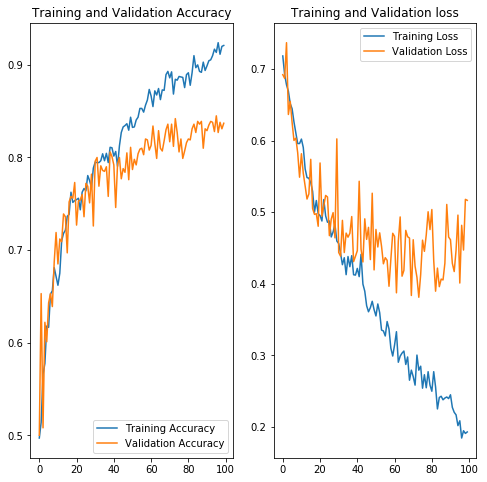

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.savefig('./foo.png')
plt.show()

#### This time, our graphs look a lot better. 

Training and validation accuracy show better corelation, and training and validation loss do not widely diverge as before.

#### Augmentation makes it a lot harder for our model to memorize the dataset!